# IMPORT

In [1]:
#packages
#basics
import os
import random
import numpy as np
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#images
import cv2

#modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import EfficientNetB0

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Data Load & Data read

In [2]:
# 데이터 불러오기
train = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
test = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')

In [3]:
# 데이터 미리보기
display(train.head())
display(test.head())

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4,1,1,1,0,1,1,0,1,0,1,1,0


In [4]:
# shape 확인
train.shape, test.shape

((9912, 14), (8, 13))

In [5]:
display(train.isnull().sum().sum())
display(test.isnull().sum().sum())

0

0

# IMAGE PATH 생성

In [6]:
# 이미지 경로 불러오는 함수 생성
# image_path
def create_image_path(ID, isTrain=True):
    if isTrain:
        return '../input/petfinder-pawpularity-score/train/' + ID + ".jpg"
    else:
        return '../input/petfinder-pawpularity-score/test/' + ID + ".jpg"

In [7]:
train["img_path"] = train["Id"].apply(create_image_path,isTrain=True)
test["img_path"] = test["Id"].apply(create_image_path,isTrain=False)

# Hyperparameter Setting

In [8]:
config = {
    'IMG_SIZE':80,
    'EPOCHS':50,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':200,
    'SEED':42
}

# Random Seed 고정

In [9]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(config['SEED'])

# Train / Valid 나누기

In [10]:
train_df, val_df, train_labels, val_labels = train_test_split(
                                                    train.drop(columns=['Pawpularity']), 
                                                    train['Pawpularity'], 
                                                    test_size=0.2, 
                                                    random_state=config['SEED']
                                                )

In [11]:
train_df.shape, val_df.shape, train_labels.shape, val_labels.shape

((7929, 14), (1983, 14), (7929,), (1983,))

In [12]:
test_df = test
test_df.shape

(8, 14)

# Custom Dataset

In [13]:
# 이미지 변환하는 함수
def transform(image):
    image = cv2.resize(image, (config["IMG_SIZE"],config["IMG_SIZE"]), interpolation=cv2.INTER_AREA)
    image = image/255
    return image

In [14]:
def CustomDataset(img_path, transforms):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
    if transforms is not None:
        image = transform(image=image)
    return image

In [15]:
def img_load_and_custom(img_path):
    img_set = []
    run_transform = 1
    for path in img_path:
        img = CustomDataset(path, run_transform)
        img_set.append(img)
    return img_set

In [16]:
train_img_set = img_load_and_custom(train_df['img_path'])
val_img_set = img_load_and_custom(val_df['img_path'])
test_img_set = img_load_and_custom(test_df['img_path'])

In [17]:
train_tabular_set = train_df.drop(columns=['Id', 'img_path'])
val_tabular_set = val_df.drop(columns=['Id', 'img_path'])
test_tabular_set = test_df.drop(columns=['Id', 'img_path'])

In [18]:
np.array(train_img_set).shape

(7929, 80, 80, 3)

In [19]:
train_img_set = np.array(train_img_set)
val_img_set = np.array(val_img_set)
test_img_set = np.array(test_img_set)

In [20]:
train_tabular_set = np.array(train_tabular_set)
val_tabular_set = np.array(val_tabular_set)
test_tabular_set = np.array(test_tabular_set)

In [21]:
print(train_img_set[0].shape)
print(train_tabular_set[0].shape)

(80, 80, 3)
(12,)


# Model Build

In [22]:
class ImgFeatureExtractor(tf.keras.Model):
    def __init__(self):
        super(ImgFeatureExtractor, self).__init__()
#       본대회 규정상 인터넷 사용 금지 --> 전이학습 불가 (인터넷에서 다운받아야 함)
#       self.backbone = EfficientNetB0(include_top=False, weights='imagenet')
        self.conv1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(80,80,3))
        self.pool1 = tf.keras.layers.MaxPool2D((2,2))
        
        self.conv2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D((2,2))
        
        self.conv3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu')
        self.pool3 = tf.keras.layers.MaxPool2D((2,2))
        
        
        self.flatten = tf.keras.layers.Flatten()
        # 62 -> 128
        self.dense1 = tf.keras.layers.Dense(128,activation='relu')
        self.drop = tf.keras.layers.Dropout(0.1)
        self.dense2 = tf.keras.layers.Dense(64,activation='linear')
        
    def call(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.drop(x)
        x = self.dense2(x)
        return x

In [23]:
class TabularFeatureExtractor(tf.keras.Model):
    def __init__(self):
        super(TabularFeatureExtractor, self).__init__()
        self.Dense1 = tf.keras.layers.Dense(64)
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.activ1 = tf.keras.layers.LeakyReLU()
        self.Dense2 = tf.keras.layers.Dense(64)
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.activ2 = tf.keras.layers.LeakyReLU()
        self.Dense3 = tf.keras.layers.Dense(64)
        self.norm3 = tf.keras.layers.BatchNormalization()
        self.activ3 = tf.keras.layers.LeakyReLU()
        self.Dense4 = tf.keras.layers.Dense(64)
        
    def call(self, x):
        x = self.Dense1(x)
        x = self.norm1(x)
        x = self.activ1(x)
        
        x = self.Dense2(x)
        x = self.norm2(x)
        x = self.activ2(x)
        
        x = self.Dense3(x)
        x = self.norm3(x)
        x = self.activ3(x)
        
        x = self.Dense4(x)
        return x

In [24]:
class Model_build(tf.keras.Model):
    def __init__(self):
        super(Model_build, self).__init__()
        self.img_feature_extractor = ImgFeatureExtractor()
        self.tabular_feature_extractor = TabularFeatureExtractor()
        self.regression = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        img_feature = self.img_feature_extractor(inputs[0])
        tabular_feature = self.tabular_feature_extractor(inputs[1])
        feature = tf.keras.layers.Concatenate(axis=-1)([img_feature, tabular_feature])
        output = self.regression(feature)
        return output

In [25]:
model = Model_build()

input1 = tf.keras.layers.Input(train_img_set[0].shape)
input2 = tf.keras.layers.Input(train_tabular_set[0].shape[0])

model([input1,input2])

# 모델 요약
model.summary()

2022-12-10 17:13:50.357531: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 17:13:50.469519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 17:13:50.470333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-10 17:13:50.471625: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model_build"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_feature_extractor (ImgFe multiple                  556256    
_________________________________________________________________
tabular_feature_extractor (T multiple                  14080     
_________________________________________________________________
dense_6 (Dense)              multiple                  129       
Total params: 570,465
Trainable params: 570,081
Non-trainable params: 384
_________________________________________________________________


In [26]:
model.compile(
    loss = 'mse', 
    optimizer = tf.keras.optimizers.Adam(learning_rate=config['LEARNING_RATE']), 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
history = model.fit(
    (train_img_set, train_tabular_set),
    train_labels, 
    batch_size=config["BATCH_SIZE"],
    validation_data = ((val_img_set, val_tabular_set) ,val_labels),
    steps_per_epoch = len(train_img_set) // config["BATCH_SIZE"],
    epochs = config["EPOCHS"]
)

2022-12-10 17:13:52.987821: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 608947200 exceeds 10% of free system memory.
2022-12-10 17:13:53.679839: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 608947200 exceeds 10% of free system memory.
2022-12-10 17:13:54.189495: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-12-10 17:13:57.119513: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


39/39 [==============================] - 9s 33ms/step - loss: 1443.4766 - rmse: 37.9931 - val_loss: 631.3016 - val_rmse: 25.1257
Epoch 2/50
39/39 [==============================] - 1s 22ms/step - loss: 470.6891 - rmse: 21.6954 - val_loss: 472.1790 - val_rmse: 21.7297
Epoch 3/50
39/39 [==============================] - 1s 22ms/step - loss: 455.5927 - rmse: 21.3446 - val_loss: 467.8333 - val_rmse: 21.6295
Epoch 4/50
39/39 [==============================] - 1s 22ms/step - loss: 443.2203 - rmse: 21.0528 - val_loss: 472.6581 - val_rmse: 21.7407
Epoch 5/50
39/39 [==============================] - 1s 25ms/step - loss: 445.3729 - rmse: 21.1039 - val_loss: 464.9432 - val_rmse: 21.5625
Epoch 6/50
39/39 [==============================] - 1s 21ms/step - loss: 439.0481 - rmse: 20.9535 - val_loss: 464.1190 - val_rmse: 21.5434
Epoch 7/50
39/39 [==============================] - 1s 21ms/step - loss: 440.7108 - rmse: 20.9931 - val_loss: 462.8455 - val_rmse: 21.5138
Epoch 8/50
39/39 [===================

### tabular 512 출력일 때 
loss: 416.8122 - rmse: 20.4160 - val_loss: 446.0490 - val_rmse: 21.1199

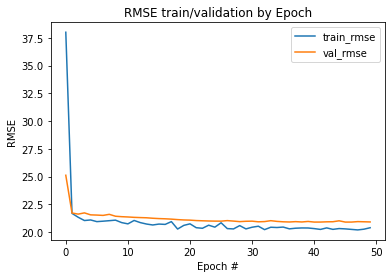

In [28]:
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right")

In [29]:
predict = model.predict([test_img_set,test_tabular_set])
predict

array([[30.471836],
       [26.63395 ],
       [30.653095],
       [22.370447],
       [25.515615],
       [28.55825 ],
       [18.374111],
       [24.43773 ]], dtype=float32)

In [30]:
submit = pd.read_csv('../input/petfinder-pawpularity-score/sample_submission.csv')
submit.head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,67.75
1,43a2262d7738e3d420d453815151079e,59.15
2,4e429cead1848a298432a0acad014c9d,20.02
3,80bc3ccafcc51b66303c2c263aa38486,94.53
4,8f49844c382931444e68dffbe20228f4,89.82


In [31]:
submit['Pawpularity'] = predict
submit['Pawpularity'] 

0    30.471836
1    26.633949
2    30.653095
3    22.370447
4    25.515615
5    28.558250
6    18.374111
7    24.437731
Name: Pawpularity, dtype: float32

In [32]:
submit.to_csv('submission.csv',index=False)